In [10]:
import requests
import pandas as pd
import spacy
from textstat import textstat
import re
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import pickle


In [11]:
nlp = spacy.load("en_core_web_sm")


In [12]:
print(torch.__version__)
print(torch.version.cuda)  # Should not be None
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
11.8
True
1
NVIDIA GeForce RTX 2070 with Max-Q Design


In [13]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
if torch.cuda.is_available():
    print("cuda available!")
    model.to("cuda")
else:
    print('cuda not available!')


cuda available!


In [14]:
import requests
from tqdm import tqdm


def get_category_members(category, cmtype="page", namespace=0, limit=500):
    """
    Fetches members of a given Wikipedia category.

    :param category: Category name without the 'Category:' prefix
    :param cmtype: 'page', 'subcat', or 'file'
    :param namespace: Namespace index (0 for articles)
    :param limit: Number of results per request (max 500 for users)
    :returns: List of dicts with 'pageid' and 'title'
    """
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    members = []
    params = {
        "action": "query",
        "format": "json",
        "list": "categorymembers",
        "cmtitle": f"Category:{category}",
        "cmtype": cmtype,
        "cmlimit": limit,
        "cmnamespace": namespace,
    }
    while True:
        res = S.get(URL, params=params)
        data = res.json()
        batch = data.get("query", {}).get("categorymembers", [])
        members.extend(batch)
        if "continue" in data:
            params.update(data["continue"])
        else:
            break
    return members


In [15]:
def fetch_articles_from_categories(categories, include_subcats=False, max_subcat_depth=1):
    """
    Given a list of category names, fetches all articles in them.
    Optionally includes pages from subcategories up to specified depth.

    :param categories: List of category names (strings without prefix)
    :param include_subcats: Whether to traverse into subcategories
    :param max_subcat_depth: Maximum depth for subcategory traversal
    :returns: Set of page titles
    """
    all_articles = set()
    seen_cats = set()

    def _recurse(cat, depth):
        if cat in seen_cats or depth < 0:
            return
        seen_cats.add(cat)

        # Fetch pages
        pages = get_category_members(cat, cmtype="page")
        for p in pages:
            all_articles.add(p["title"])

        if include_subcats and depth > 0:
            subcats = get_category_members(cat, cmtype="subcat", namespace=14)
            for sc in subcats:
                sc_name = sc["title"].replace("Category:", "")
                _recurse(sc_name, depth - 1)

    for cat in tqdm(categories, desc="Traversing categories"):
        _recurse(cat, max_subcat_depth)

    return all_articles


In [16]:
categories = [
    "Politics",
    "History"
]

In [17]:
root_categories = {
    "Politics": [
        "Politics", "Political history", "Elections", "Political parties"
    ],
    "Science & Medicine": [
        "Science", "Medicine", "Biology", "Physics", "Chemistry"
    ],
    "History": [
        "History", "Military history", "History by country"
    ],
    "Technology": [
        "Technology", "Computing", "Engineering"
    ],
    "Popular Culture": [
        "Popular culture", "Music", "Television", "Film", "Video games"
    ]
}


In [18]:
all_records = []
for stratum, roots in root_categories.items():
    for root in roots:
        articles = fetch_articles_from_categories([root], include_subcats=True, max_subcat_depth=1)
        for title in articles:
            all_records.append({"stratum": stratum, "root": root, "title": title})
pd.DataFrame(all_records).to_csv("articles_by_category_1_recurse.csv", index=False)


Traversing categories: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


In [27]:
# print len of all_records including subcats
len(all_records)




28695

In [20]:

articles = fetch_articles_from_categories(categories, include_subcats=True, max_subcat_depth=2)
print(f"Fetched {len(articles)} articles from categories and subcategories.")

# Save to file or integrate into your pipeline
with open("article_names_list.pkl", "wb") as f:
    pickle.dump(articles, f)

Traversing categories:   0%|          | 0/2 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# read article_names_list.pkl and co

In [118]:
# Load the articles from the saved file
with open("article_names_list.pkl", "rb") as f:
    articles = pickle.load(f)
print(articles)

{'Ahnenerbe', '2024 Belizean municipal elections', 'Convention of Aguascalientes', 'Outline of the Ottoman Empire', 'Plenitudo potestatis', 'S-Alternative', 'Sentientism', 'Danish question', 'Macedonism', 'Madman theory', 'Cordobazo', 'Knights of Reciprocity', 'Herod of Chalcis', '1801 in Iceland', 'Inventory Stela', '2025 in politics', 'List of Wasserstein Fellows', 'Umi ni Ikuru Hitobito', 'Provisional Government of the Irish Republic', 'Andrei Sakharov', 'Doughface', 'Matteo I Visconti', 'Militarization of police', 'Death of Gloria Ramirez', 'Evolution of the Philippine Flag', 'Nazism', 'Gulargate', 'Discourse of power', 'Management', 'David Whiting', 'List of historical fiction by time period', 'Cultural identity', 'Criminalization of politics', 'Four-year junior college', 'UNESCO International Days', 'Harold More Cooper', "Dutch farmers' protests", 'NIS Directive', 'Synthetic Environment for Analysis and Simulations', 'The Green Inferno (film)', 'Reduction (military)', 'Democracy 

In [120]:
START_TIMESTAMP = "2022-01-01T00:00:00Z"
END_TIMESTAMP = "2024-01-31T23:59:59Z"


In [121]:
columns = [
    "page_title", "rev_id", "timestamp", "user", "is_bot", "content"
]
tiny_revs = pd.DataFrame(columns=columns)


In [122]:
def is_bot_username(username: str) -> bool:
    return username.lower().endswith("bot")


In [78]:
import requests
import pandas as pd
from dateutil import parser
import time
import os
from requests.exceptions import ChunkedEncodingError, RequestException
from urllib3.exceptions import ProtocolError


def fetch_revision_snapshots(
    title: str,
    start_ts: str,
    end_ts: str,
    freq: str = "7D",
    bot_test_fn: callable = None,
    carry_forward: bool = True,
    max_retries: int = 3,
    backoff_factor: float = 1.0,
    checkpoint_path: str = None,
    checkpoint_interval: int = 1000,
) -> pd.DataFrame:
    """
    Fetches all revisions for `title` between start_ts and end_ts (inclusive),
    returns snapshots at the given frequency, and optionally checkpoints progress.

    Args:
      title             : Wikipedia page title
      start_ts          : ISO8601 timestamp string, e.g. "2020-01-01T00:00:00Z"
      end_ts            : ISO8601 timestamp string, e.g. "2020-12-31T23:59:59Z"
      freq              : pandas offset alias (e.g. "7D")
      bot_test_fn       : callable to flag bots (user->bool)
      carry_forward     : reuse last snapshot if no newer revision
      max_retries       : number of retries on network failure
      backoff_factor    : multiplier for retry backoff in seconds
      checkpoint_path   : path to pickle intermediate `all_revs`
      checkpoint_interval: save checkpoint every N revisions

    Returns:
      DataFrame with columns [page_title, snapshot_ts, rev_id, timestamp, user, is_bot, content]
    """
    session = requests.Session()
    API_URL = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "rvprop": "ids|timestamp|user|comment|content",
        "rvstart": end_ts,
        "rvend": start_ts,
        "rvlimit": "max",
        "titles": title,
        "redirects": 1,
        "rvslots": "main",
    }
    all_revs = []
    rev_count = 0

    # resume from checkpoint if exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            all_revs = pd.read_pickle(checkpoint_path)
            rev_count = len(all_revs)
        except Exception:
            all_revs = []
            rev_count = 0

    try:
        # 1) Fetch all revisions with retry logic
        while True:
            for attempt in range(1, max_retries + 1):
                try:
                    resp = session.get(API_URL, params=params, timeout=30)
                    resp.raise_for_status()
                    data = resp.json()
                    break
                except (ChunkedEncodingError, ProtocolError, RequestException):
                    if attempt == max_retries:
                        raise
                    time.sleep(backoff_factor * (2 ** (attempt - 1)))
            pages = data.get("query", {}).get("pages", {})
            for page in pages.values():
                for rev in page.get("revisions", []) or []:
                    user = rev.get("user", "")
                    ts_str = rev.get("timestamp")
                    if not ts_str:
                        continue
                    ts = parser.isoparse(ts_str)
                    all_revs.append({
                        "rev_id": rev.get("revid"),
                        "timestamp": ts,
                        "user": user,
                        "is_bot": bot_test_fn(user) if bot_test_fn else False,
                        "content": rev.get("slots", {}).get("main", {}).get("", ""),
                    })
                    rev_count += 1
                    # checkpoint
                    if checkpoint_path and rev_count % checkpoint_interval == 0:
                        pd.to_pickle(pd.DataFrame(all_revs), checkpoint_path)
            if "continue" in data:
                params.update(data["continue"])
            else:
                break
        # final checkpoint
        if checkpoint_path:
            pd.to_pickle(pd.DataFrame(all_revs), checkpoint_path)
    except Exception:
        # on error, save current progress
        if checkpoint_path:
            pd.to_pickle(pd.DataFrame(all_revs), checkpoint_path)
        raise

    # 2) Build and sort DataFrame
    df = pd.DataFrame(all_revs)
    if df.empty:
        return pd.DataFrame(columns=["page_title","snapshot_ts","rev_id","timestamp","user","is_bot","content"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # 3) Generate sample times
    sample_times = pd.date_range(
        start=parser.isoparse(start_ts),
        end=parser.isoparse(end_ts),
        freq=freq
    )

    # 4) Snapshot selection
    snapshots = []
    idx = 0
    last_row = None
    for snap_t in sample_times:
        has_new_revision = False
        while idx < len(df) and df.loc[idx, "timestamp"] <= snap_t:
            last_row = df.loc[idx]
            has_new_revision = True
            idx += 1
        if last_row is None:
            continue
        if not carry_forward and not has_new_revision:
            continue
        row = last_row.copy()
        row["page_title"] = title
        row["snapshot_ts"] = snap_t
        snapshots.append(row)

    snap_df = pd.DataFrame(snapshots)
    cols = ["page_title","snapshot_ts","rev_id","timestamp","user","is_bot","content"]
    return snap_df[cols] if not snap_df.empty else pd.DataFrame(columns=cols)


# New code -- experimental

In [123]:
import requests
import pandas as pd
from dateutil import parser
from dateutil.relativedelta import relativedelta
import time
import os
from requests.exceptions import ChunkedEncodingError, RequestException
from urllib3.exceptions import ProtocolError


def fetch_revision_snapshots(
    title: str,
    start_ts: str,
    end_ts: str,
    freq: str = "7D",
    bot_test_fn: callable = None,
    carry_forward: bool = True,
    max_retries: int = 3,
    backoff_factor: float = 1.0,
    checkpoint_path: str = None,
    checkpoint_interval: int = 1000,
) -> pd.DataFrame:
    """
    Fetches all revisions (including full content) for `title` between start_ts and end_ts,
    then returns snapshots at given frequency with content included.

    This single-pass approach avoids a separate content-fetch phase by requesting content
    alongside metadata, ensuring `content` is always populated.

    Args (same as before):
      - title, start_ts, end_ts, freq, bot_test_fn, carry_forward
      - max_retries, backoff_factor, checkpoint_path, checkpoint_interval

    Returns:
      DataFrame with columns ['page_title','snapshot_ts','rev_id','timestamp',
      'user','is_bot','content']
    """
    session = requests.Session()
    API_URL = "https://en.wikipedia.org/w/api.php"

    # Phase 1: Fetch metadata + content in one pass
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        # include content slot
        "rvprop": "ids|timestamp|user|content",
        "rvstart": end_ts,
        "rvend": start_ts,
        "rvlimit": "max",
        "titles": title,
        "redirects": 1,
        "rvslots": "main",
    }
    all_revs = []
    retries = 0
    while True:
        try:
            resp = session.get(API_URL, params=params, timeout=30)
            resp.raise_for_status()
            data = resp.json()
        except (ChunkedEncodingError, ProtocolError, RequestException):
            if retries >= max_retries:
                raise
            retries += 1
            time.sleep(backoff_factor * (2 ** (retries - 1)))
            continue
        pages = data.get("query", {}).get("pages", {})
        for page in pages.values():
            for rev in page.get("revisions", []) or []:
                ts_str = rev.get("timestamp")
                if not ts_str:
                    continue
                ts = parser.isoparse(ts_str)
                user = rev.get("user", "")
                # content slot
                content = rev.get("slots", {}).get("main", {}).get("*", "")
                all_revs.append({
                    "rev_id": rev.get("revid"),
                    "timestamp": ts,
                    "user": user,
                    "is_bot": bot_test_fn(user) if bot_test_fn else False,
                    "content": content,
                })
        if "continue" in data:
            params.update(data["continue"])
        else:
            break

    # If no revisions, return empty DataFrame
    if not all_revs:
        return pd.DataFrame(columns=["page_title","snapshot_ts","rev_id",
                                      "timestamp","user","is_bot","content"])

    # Build DataFrame and sort
    df = pd.DataFrame(all_revs)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Phase 2: Snapshot selection
    timestamps = df["timestamp"]
    sample_times = pd.date_range(
        start=pd.to_datetime(start_ts),
        end=pd.to_datetime(end_ts),
        freq=freq,
        tz=timestamps.dt.tz
    )
    snaps = []
    last_snap_time = None
    for snap_t in sample_times:
        pos = timestamps.searchsorted(snap_t, side='right') - 1
        if pos < 0:
            continue
        rev_time = timestamps.iloc[pos]
        # skip if no carry_forward and no new revision
        if not carry_forward and last_snap_time is not None and rev_time <= last_snap_time:
            last_snap_time = snap_t
            continue
        row = df.iloc[pos].to_dict()
        row["snapshot_ts"] = snap_t
        row["page_title"] = title
        snaps.append(row)
        last_snap_time = snap_t

    df_snap = pd.DataFrame(snaps)
    cols = ["page_title","snapshot_ts","rev_id","timestamp","user","is_bot","content"]
    return df_snap[cols] if not df_snap.empty else pd.DataFrame(columns=cols)


In [126]:
sample_pages = list(articles)[:100]  # Limit to first 100 pages for testing 

In [127]:
# add a progress bar to the loop
from tqdm.auto import tqdm
tqdm.pandas(desc="Fetching revisions")
rows = []
for pg in tqdm(sample_pages, desc="Fetching revisions"):
    revs = fetch_revision_snapshots(
        pg, START_TIMESTAMP, END_TIMESTAMP,
        freq="1ME", bot_test_fn=is_bot_username, carry_forward=False
    )
    # Convert DataFrame rows to dictionaries
    for _, r in revs.iterrows():
        rows.append({
            "page_title": pg,
            "rev_id": r["rev_id"],
            "timestamp": r["timestamp"],
            "user": r["user"],
            "is_bot": r["is_bot"],
            "content": r["content"]
        })
tiny_revs = pd.DataFrame(rows)

Fetching revisions:   0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
tiny_revs.head(100)
# tiny_revs.shape



,page_title,rev_id,timestamp,user,is_bot,content
0,Ahnenerbe,1066308021,2022-01-17 19:25:26+00:00,Cilidus,False,{{short description|Nazi political and pseudos...
1,Ahnenerbe,1073779994,2022-02-24 15:12:19+00:00,Doug Weller,False,{{short description|Nazi political and pseudos...
2,Ahnenerbe,1079741195,2022-03-28 11:06:37+00:00,63.230.237.5,False,{{short description|Nazi political and pseudos...
3,Ahnenerbe,1084410583,2022-04-24 09:28:03+00:00,Doug Weller,False,{{short description|Nazi political and pseudos...
4,Ahnenerbe,1100725471,2022-07-27 10:30:25+00:00,Treebrawl,False,{{short description|Nazi political and pseudos...
...,...,...,...,...,...,...
95,Madman theory,1151397596,2023-04-23 20:13:35+00:00,93.72.49.123,False,{{Short description|Feature of Richard Nixon's...
96,Madman theory,1153303031,2023-05-05 13:11:01+00:00,Thenightaway,False,{{Short description|Feature of Richard Nixon's...
97,Madman theory,1160935521,2023-06-19 16:34:30+00:00,Tobby72,False,{{Short description|Feature of Richard Nixon's...
98,Madman theory,1172757085,2023-08-29 03:15:19+00:00,Citation bot,True,{{Short description|Feature of Richard Nixon's...


In [129]:
tiny_revs.to_pickle("mini_history_politics_100_articles_every1m_before_cleaning.pkl")
# save to csv
tiny_revs.to_csv("mini_history_politics_100_articles_every1m_before_cleaning.csv", index=False)



---
# 4 Text Cleaning & Sentence/Token Parsing



In [131]:
def clean_text(wikitext: str) -> str:
    # Remove wiki markup—keep plain text for prototype
    text = re.sub(r"<ref>.*?</ref>", "", wikitext, flags=re.DOTALL)
    text = re.sub(r"\{\{.*?\}\}", "", text)  # simple template removal
    text = re.sub(r"\[\[([^|\]]*\|)?([^\]]+)\]\]", r"\2", text)  # keep link text
    text = re.sub(r"''+", "", text)  # remove italic/bold
    # Remove non-alphabetic chars except basic punctuation
    text = re.sub(r"[^A-Za-z0-9 \.\,\!\?\-\'\"]+", " ", text)
    # Lowercase and collapse whitespace
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [132]:
tiny_revs["plain_text"] = tiny_revs["content"].apply(clean_text)


In [133]:
def parse_with_spacy(text: str):
    doc = nlp(text)
    total_tokens = len(doc)

    # POS proportions
    pos_counts = doc.count_by(spacy.attrs.POS)
    upos_props = {nlp.vocab[pos].text: cnt / total_tokens for pos, cnt in pos_counts.items()}

    # Dependency depth approximation
    def token_depth(token):
        depth = 0
        while token != token.head:
            token = token.head
            depth += 1
        return depth

    depths = [token_depth(token) for token in doc]
    mean_depth = sum(depths) / total_tokens if total_tokens else 0

    # Clause ratio
    clause_tags = sum(1 for token in doc if token.dep_ in ("advcl", "ccomp", "xcomp"))
    clause_ratio = clause_tags / (len(list(doc.sents)) or 1)

    # Passive voice ratio
    passive_count = sum(1 for token in doc if token.dep_ == "auxpass")
    voice_ratio = (total_tokens - passive_count) / (total_tokens or 1)

    return {
        "upos_props": upos_props,
        "mean_dep_depth": mean_depth,
        "clause_ratio": clause_ratio,
        "voice_ratio": voice_ratio,
        "sentences": [sent.text for sent in doc.sents],  # Convert Span to text
        "tokens": [token.text for token in doc]
    }

In [134]:
# Test the parsing function on a small sample
sample_parsed = tiny_revs["plain_text"].iloc[:10].apply(parse_with_spacy)
sample_parsed[0]


{'upos_props': {'PROPN': 0.08840008300477277,
  'NOUN': 0.23324341149616104,
  'X': 0.0005187798298402158,
  'NUM': 0.023656360240713842,
  'PUNCT': 0.10686864494708445,
  'VERB': 0.10209587051255448,
  'ADP': 0.1245071591616518,
  'ADJ': 0.07200664038182196,
  'DET': 0.08974891056235734,
  'CCONJ': 0.02490143183233036,
  'PRON': 0.03610707615687902,
  'ADV': 0.023448848308777755,
  'SCONJ': 0.01276198381406931,
  'AUX': 0.03641834405478315,
  'PART': 0.02490143183233036,
  'INTJ': 0.0004150238638721727},
 'mean_dep_depth': 3.55353807843951,
 'clause_ratio': 0.8770949720670391,
 'voice_ratio': 0.9846441170367296,
 'sentences': ['infobox organization name ahnenerbe image ahnenerbe.svg caption emblem formation july 1, 1935 dissolved 1945 founder heinrich himmler status registered association under schutzstaffel control purpose political propaganda, br pseudo-scientific research language german the ahnenerbe , ancestral heritage operated as a think tank in nazi germany between 1935 and 19

In [135]:
# put it back into tiny_revs, add a progress bar 
from tqdm.auto import tqdm

tqdm.pandas(desc="Parsing with spaCy")
# Apply the parsing function to the 'plain_text' column with progress tracking
tiny_revs["parsed"] = tiny_revs["plain_text"].progress_apply(parse_with_spacy)

Parsing with spaCy:   0%|          | 0/829 [00:00<?, ?it/s]

In [ ]:
sample_parsed.head()

In [ ]:
# check tiny_revs
tiny_revs.head(20)

In [136]:
# write to pickle
tiny_revs.to_pickle("history_politics_100_articles_every1m_after_spacy_bedfore_delta.pkl")

---
# 5 Feature Extraction Functions


In [137]:
# tiny_trigger = {"delves", "pivotal", "showcasing", "leverage", "optimize"}


def compute_delta(text: str, trigger_set: set, baseline_freq: float = 0.0001):
    tokens = text.split()
    if not tokens:
        return 0.0
    freq = sum(1 for t in tokens if t in trigger_set) / len(tokens)
    return freq - baseline_freq


In [138]:
# read from combined file into python set
trigger_file = "combined_chatgpt_words.csv"
tiny_trigger = set(pd.read_csv(trigger_file, header=None)[0].tolist())

In [139]:
# add delta column to tiny_revs
tiny_revs["delta"] = tiny_revs["plain_text"].apply(lambda txt: compute_delta(txt, tiny_trigger))

In [140]:

def compute_perplexity_and_burstiness(text: str, max_length: int = 512):
    """
    GPU-optimized perplexity calculation with input validation for GPT-2
    """
    if not text or len(text.strip()) == 0:
        return 0.0, 0.0

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if not torch.cuda.is_available():
        print("WARNING: CUDA not available!")
        return 0.0, 0.0

    if model.device.type != "cuda":
        model.to("cuda")

    try:
        encodings = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length
        )
        input_ids = encodings.input_ids

        # Clamp input_ids to valid range
        vocab_size = model.config.vocab_size
        if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)

        if input_ids.shape[1] < 5:
            return 0.0, 0.0

        input_ids = input_ids.to("cuda")

        chunk_size = 8
        total_loss = 0.0
        total_tokens = 0

        for i in range(0, input_ids.shape[1], chunk_size):
            end_idx = min(i + chunk_size, input_ids.shape[1])
            chunk = input_ids[:, i:end_idx]
            try:
                with torch.no_grad():
                    outputs = model(chunk, labels=chunk)
                chunk_loss = outputs.loss.item() * chunk.shape[1]
                total_loss += chunk_loss
                total_tokens += chunk.shape[1]
            except Exception as e:
                print(f"Skipping chunk {i}:{end_idx} due to error: {str(e)}")
                continue

        if total_tokens == 0:
            return 0.0, 0.0

        avg_loss = total_loss / total_tokens
        ppl = torch.exp(torch.tensor(avg_loss)).item()

        log_probs = []
        positions = [min(10, input_ids.shape[1] - 1), min(20, input_ids.shape[1] - 1)]
        for pos in positions:
            if pos < 5:
                continue
            try:
                segment = input_ids[:, :pos]
                with torch.no_grad():
                    out = model(segment, labels=segment)
                log_probs.append(-out.loss.item())
            except Exception:
                continue

        burstiness = float(pd.Series(log_probs).std()) if len(log_probs) > 1 else 0.0
        return ppl, burstiness

    except Exception as e:
        print(f"Error: {str(e)[:100]}...")
        return 0.0, 0.0

In [ ]:
# Test with a small sample first
small_text = tiny_revs["plain_text"].iloc[2][:10000]  # Just the first 10000 chars
ppl, burst = compute_perplexity_and_burstiness(small_text)
print(f"Perplexity: {ppl}, Burstiness: {burst}")

In [141]:
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing perplexity and burstiness")
# Apply the perplexity and burstiness function to the 'plain_text' column with progress tracking
tiny_revs[["perplexity", "burstiness"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_perplexity_and_burstiness).tolist(),
                 index=tiny_revs.index)


Computing perplexity and burstiness:   0%|          | 0/829 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [142]:
# Directly extract attributes from parsed dictionaries
tiny_revs["upos_props"] = tiny_revs["parsed"].apply(lambda x: x["upos_props"])
tiny_revs["mean_dep_depth"] = tiny_revs["parsed"].apply(lambda x: x["mean_dep_depth"])
tiny_revs["clause_ratio"] = tiny_revs["parsed"].apply(lambda x: x["clause_ratio"])
tiny_revs["voice_ratio"] = tiny_revs["parsed"].apply(lambda x: x["voice_ratio"])

In [143]:
tiny_revs.head(200)

,page_title,rev_id,timestamp,user,is_bot,content,plain_text,parsed,delta,perplexity,burstiness,upos_props,mean_dep_depth,clause_ratio,voice_ratio
0,Ahnenerbe,1066308021,2022-01-17 19:25:26+00:00,Cilidus,False,{{short description|Nazi political and pseudos...,infobox organization name ahnenerbe image ahne...,"{'upos_props': {'PROPN': 0.08840008300477277, ...",0.011925,405.911438,1.368028,"{'PROPN': 0.08840008300477277, 'NOUN': 0.23324...",3.553538,0.877095,0.984644
1,Ahnenerbe,1073779994,2022-02-24 15:12:19+00:00,Doug Weller,False,{{short description|Nazi political and pseudos...,infobox organization name ahnenerbe image ahne...,"{'upos_props': {'PROPN': 0.08826885177886111, ...",0.011921,405.911438,1.368028,"{'PROPN': 0.08826885177886111, 'NOUN': 0.23348...",3.555855,0.877095,0.984649
2,Ahnenerbe,1079741195,2022-03-28 11:06:37+00:00,63.230.237.5,False,{{short description|Nazi political and pseudos...,infobox organization name ahnenerbe image ahne...,"{'upos_props': {'PROPN': 0.08836631099140163, ...",0.011910,347.454468,1.368028,"{'PROPN': 0.08836631099140163, 'NOUN': 0.23339...",3.550088,0.877095,0.984668
3,Ahnenerbe,1084410583,2022-04-24 09:28:03+00:00,Doug Weller,False,{{short description|Nazi political and pseudos...,infobox organization name ahnenerbe image ahne...,"{'upos_props': {'PROPN': 0.0881011608623549, '...",0.011917,347.454468,1.368028,"{'PROPN': 0.0881011608623549, 'NOUN': 0.233416...",3.550166,0.877095,0.984660
4,Ahnenerbe,1100725471,2022-07-27 10:30:25+00:00,Treebrawl,False,{{short description|Nazi political and pseudos...,infobox organization name ahnenerbe image ahne...,"{'upos_props': {'PROPN': 0.0882017225277576, '...",0.011931,347.454468,1.368028,"{'PROPN': 0.0882017225277576, 'NOUN': 0.233267...",3.536163,0.874652,0.984643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Death of Gloria Ramirez,1136132775,2023-01-28 22:15:53+00:00,InjectableBacon,False,{{short description|American cancer patient}}\...,infobox person name gloria ramirez birth name ...,"{'upos_props': {'PROPN': 0.07142857142857142, ...",0.010185,238.996521,2.028279,"{'PROPN': 0.07142857142857142, 'VERB': 0.10263...",3.408460,0.870370,0.985437
196,Death of Gloria Ramirez,1140831576,2023-02-22 00:27:54+00:00,Citation bot,True,{{short description|American cancer patient}}\...,infobox person name gloria ramirez birth name ...,"{'upos_props': {'PROPN': 0.07180156657963446, ...",0.010293,238.996521,2.028279,"{'PROPN': 0.07180156657963446, 'VERB': 0.10117...",3.380548,0.827586,0.984987
197,Death of Gloria Ramirez,1146517588,2023-03-25 11:23:47+00:00,92.98.232.100,False,{{short description|American cancer patient}}\...,infobox person name gloria ramirez birth name ...,"{'upos_props': {'PROPN': 0.07180156657963446, ...",0.010293,265.180176,2.028279,"{'PROPN': 0.07180156657963446, 'VERB': 0.10117...",3.380548,0.827586,0.984987
198,Death of Gloria Ramirez,1149212427,2023-04-10 20:40:48+00:00,2600:1005:B0F1:BC0B:156F:E70D:B787:7E1D,False,{{short description|American cancer patient}}\...,infobox person name gloria ramirez birth name ...,"{'upos_props': {'PROPN': 0.07180156657963446, ...",0.010293,265.180176,2.028279,"{'PROPN': 0.07180156657963446, 'VERB': 0.10117...",3.380548,0.827586,0.984987


In [144]:
def compute_readability(text: str):
    fre = textstat.flesch_reading_ease(text)
    fog = textstat.gunning_fog(text)
    # Characters per sentence
    sentences = list(nlp(text).sents)
    chars_per_sent = sum(len(sent.text) for sent in sentences) / (len(sentences) or 1)
    # Sentences per paragraph (since we have flattened text, treat the entire text as one paragraph)
    sents_per_para = len(sentences)  # toy assumption: 1 paragraph = all sentences
    return fre, fog, chars_per_sent, sents_per_para


In [145]:
# add progress bar, this one takes a while
from tqdm import tqdm

tqdm.pandas(desc="Computing readability metrics")
# Apply the readability function to the 'plain_text' column with progress tracking
tiny_revs[["fre", "fog", "chars_per_sent", "sents_per_para"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_readability).tolist(),
                 index=tiny_revs.index)

Computing readability metrics: 100%|██████████| 829/829 [12:44<00:00,  1.08it/s]


In [146]:
def compute_vocab_diversity(text: str, window_size: int = 250):
    tokens = text.split()[:window_size] 
    unique_count = len(set(tokens))
    total_count = len(tokens) or 1
    # Normalized TTR = unique / sqrt(2 * total)
    nTTR = unique_count / ((2 * total_count) ** 0.5)
    # Word-density: lines = count of '\n' + 1, avg_line_len:
    lines = text.count("\n") + 1
    avg_line_len = sum(len(line) for line in text.split("\n")) / lines
    wd = 100 * unique_count / (lines * (avg_line_len or 1))
    return nTTR, wd


In [147]:
# add progress bar
from tqdm.auto import tqdm

tqdm.pandas(desc="Computing vocabulary diversity metrics")
# Apply the vocabulary diversity function to the 'plain_text' column with progress tracking
tiny_revs[["nTTR", "word_density"]] = \
    pd.DataFrame(tiny_revs["plain_text"].progress_apply(compute_vocab_diversity).tolist(),
                 index=tiny_revs.index)

Computing vocabulary diversity metrics:   0%|          | 0/829 [00:00<?, ?it/s]

In [148]:
def compute_line_length(text: str):
    lines = text.split("\n")
    avg_len = sum(len(line) for line in lines) / (len(lines) or 1)
    return avg_len


tiny_revs["avg_line_len"] = tiny_revs["plain_text"].apply(compute_line_length)


In [149]:
def compute_citation_delta(wikitext: str):
    # Count <ref> tags in raw wikitext
    added = len(re.findall(r"<ref[^>]*>", wikitext))
    removed = 0  # For prototype, assume no diff stored; set removed = 0
    tokens_changed = len(wikitext.split()) or 1
    return (added - removed) / tokens_changed


# If you only have full revision text (no diff), set citation_delta = (#ref tags)/tokens
tiny_revs["citation_delta"] = tiny_revs["content"].apply(lambda txt: compute_citation_delta(txt))


In [150]:
features_df = tiny_revs[[
    "page_title", "rev_id", "timestamp", "user", "is_bot",
    "delta", "perplexity", "burstiness",
    "mean_dep_depth", "clause_ratio", "voice_ratio",
    "fre", "fog", "chars_per_sent", "sents_per_para",
    "nTTR", "word_density", "avg_line_len", "citation_delta"
]].copy()



In [ ]:
# print df where page_title is "referendum"
# features_df[features_df["page_title"] == "Referendum"].head(100)

In [151]:
# # save to pickle
features_df.to_pickle("history_politics_100_articles_every1m-final.pkl")
# save to csv
features_df.to_csv("history_politics_100_articles_every1m-final.csv", index=False)

In [152]:
features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
rev_id,829.0,1.133953e+09,3.901077e+07,1.063226e+09,1.100489e+09,1.136318e+09,1.167800e+09,1.200889e+09
delta,829.0,1.420325e-02,1.276348e-02,-1.000000e-04,7.571233e-03,1.075616e-02,1.412387e-02,6.943642e-02
perplexity,820.0,5.749855e+02,5.070168e+02,1.481227e+02,2.888029e+02,4.040807e+02,7.430711e+02,4.432631e+03
burstiness,829.0,7.431883e-01,4.931281e-01,1.021134e-02,3.620239e-01,6.978601e-01,1.044522e+00,2.509217e+00
mean_dep_depth,829.0,5.329717e+00,1.758764e+01,2.579327e+00,3.384330e+00,3.521156e+00,3.812665e+00,1.961206e+02
clause_ratio,829.0,7.995183e-01,4.481126e-01,0.000000e+00,5.686275e-01,7.452830e-01,9.638554e-01,3.500000e+00
voice_ratio,829.0,9.894822e-01,5.682531e-03,9.670047e-01,9.867940e-01,9.897260e-01,9.926059e-01,1.000000e+00
fre,829.0,2.999831e+01,2.980050e+01,-2.405289e+02,2.430952e+01,3.502366e+01,4.085500e+01,7.411065e+01
fog,829.0,1.873780e+01,1.097574e+01,8.273833e+00,1.611496e+01,1.707448e+01,1.854930e+01,1.276888e+02
chars_per_sent,829.0,2.885714e+02,9.216892e+02,7.351282e+01,1.512610e+02,1.657350e+02,1.809382e+02,1.007450e+04


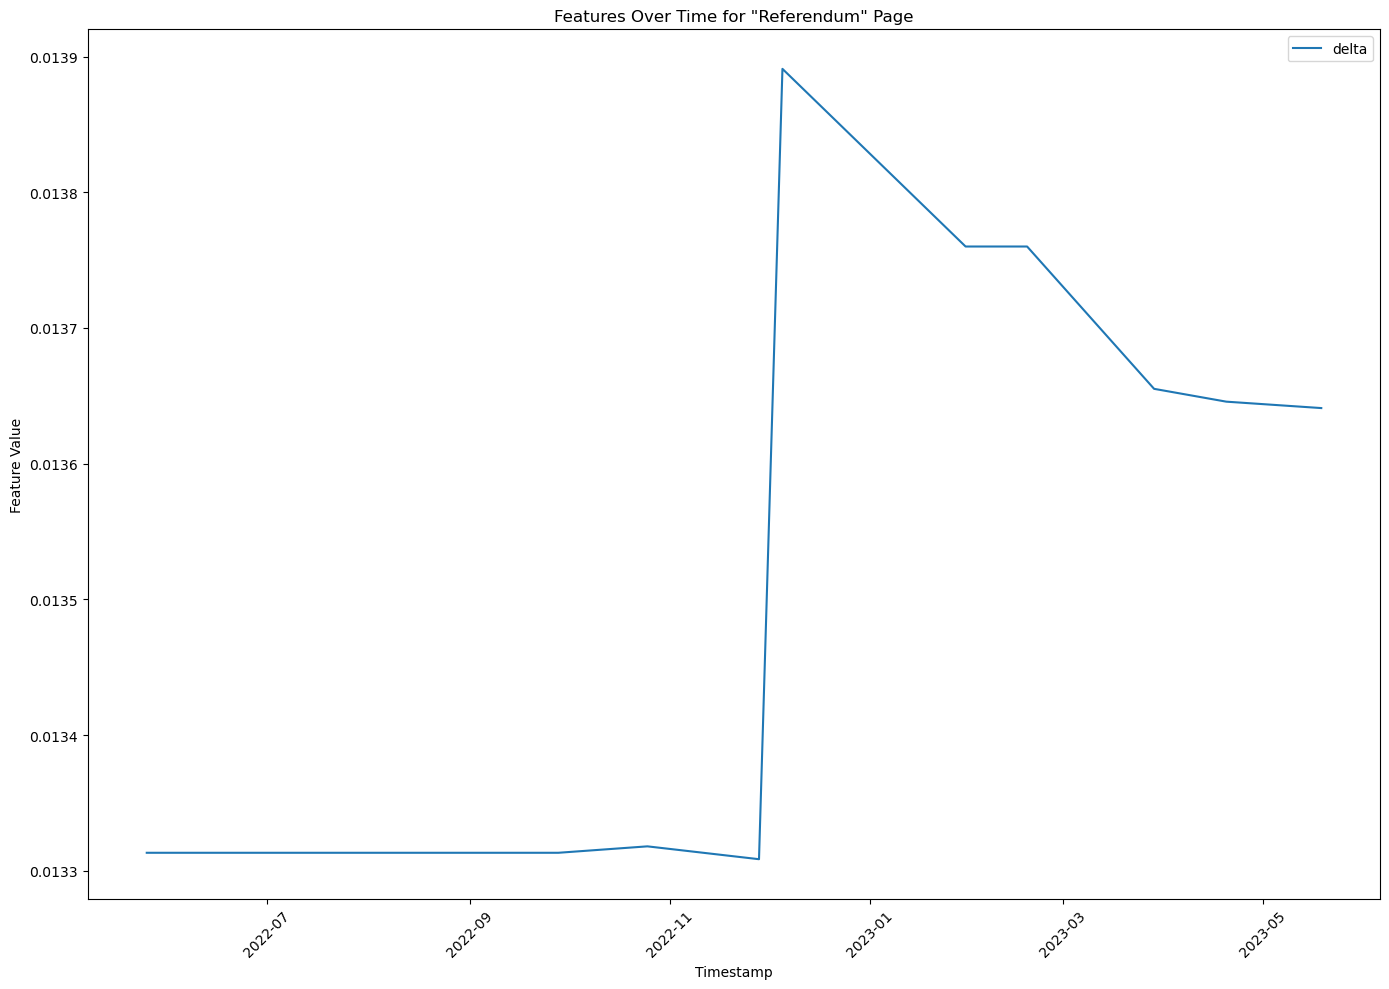

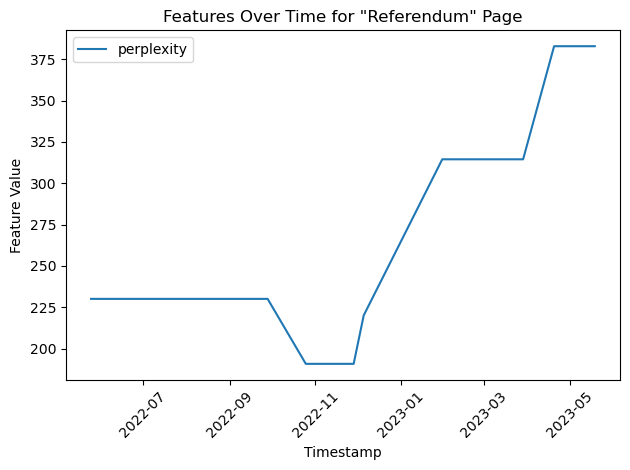

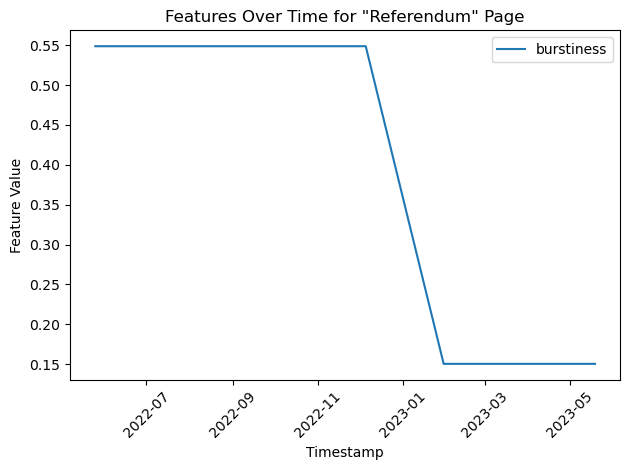

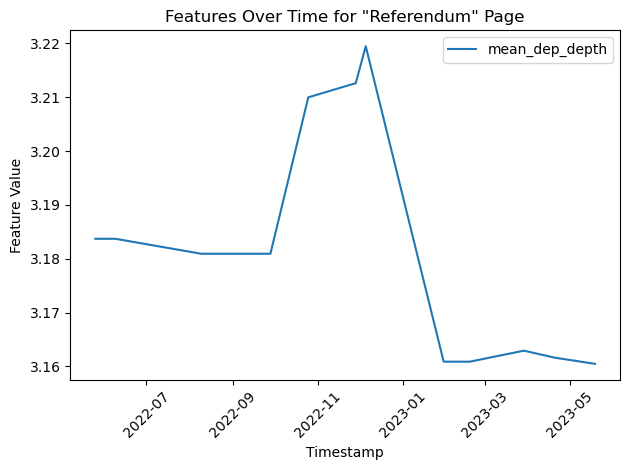

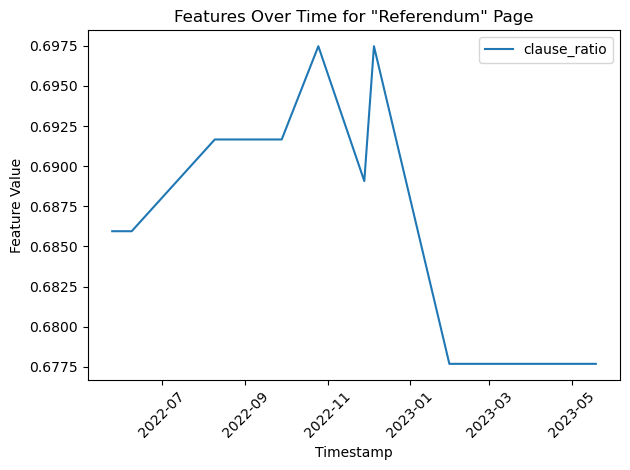

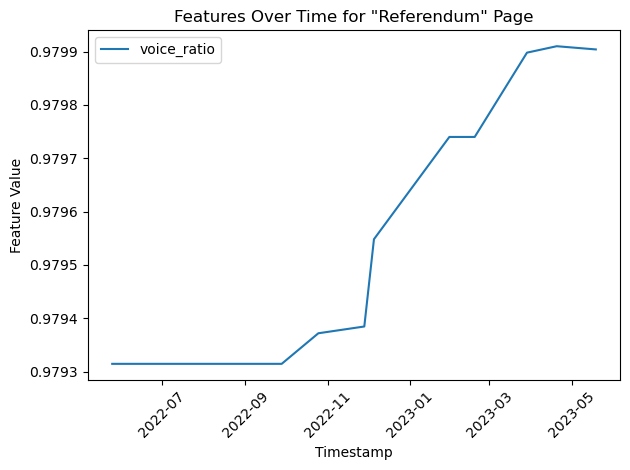

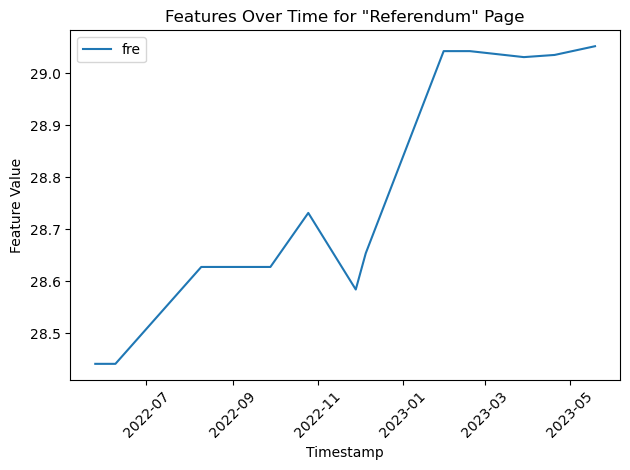

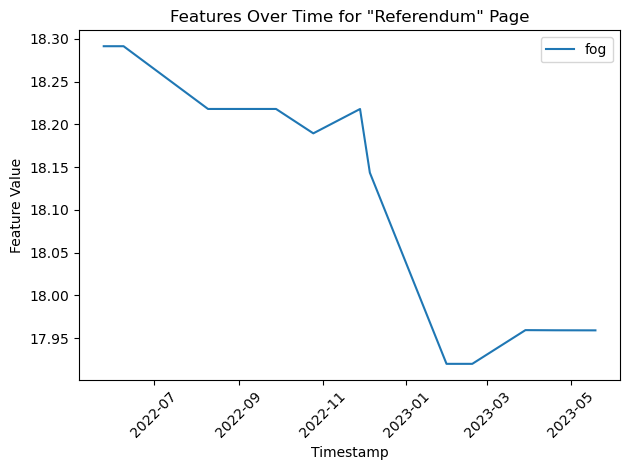

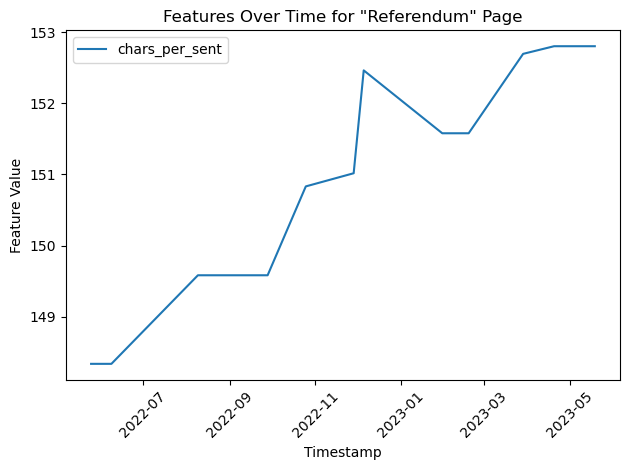

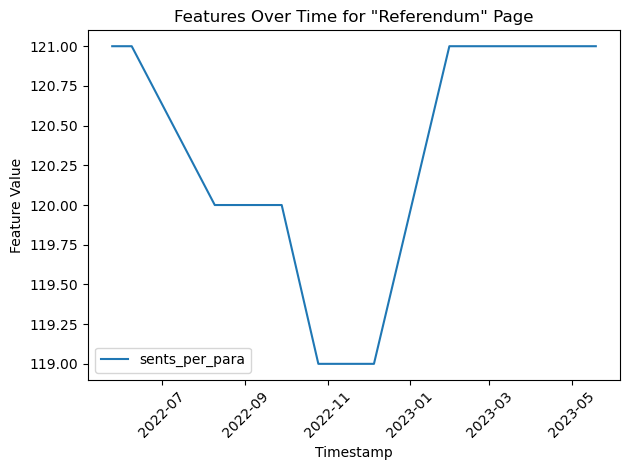

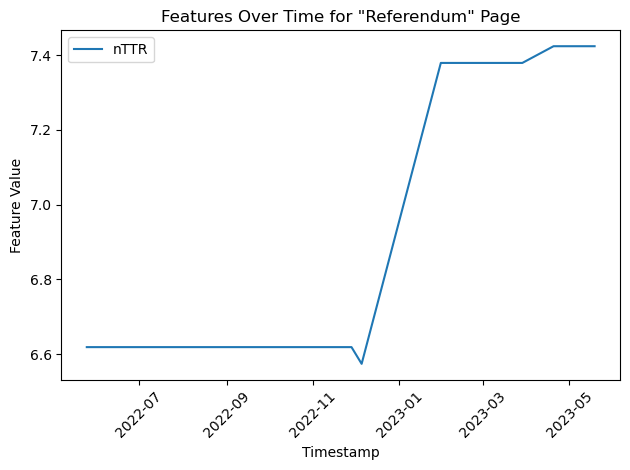

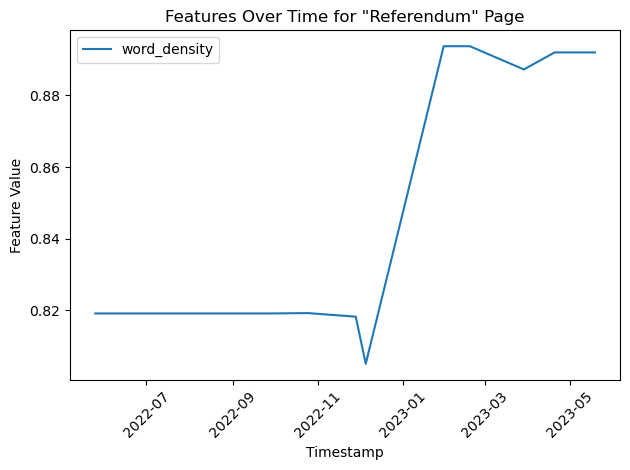

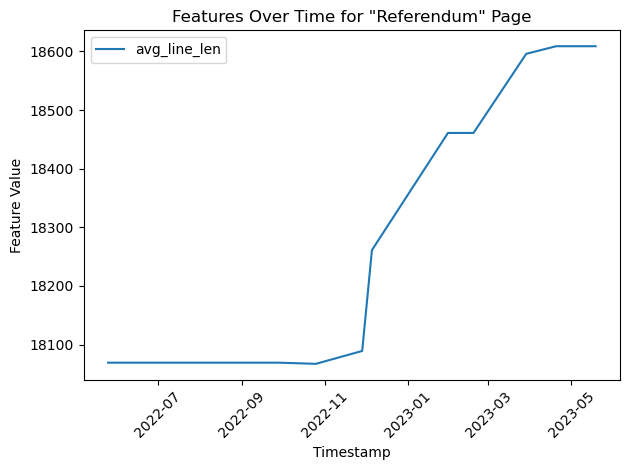

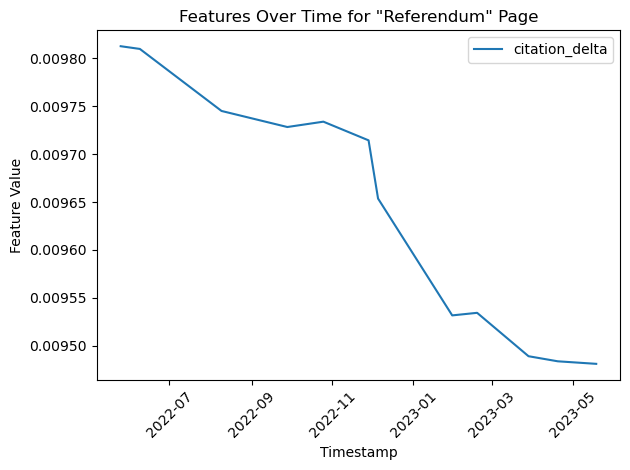

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with your actual file path
df = pd.read_csv('History-every1M-final.csv')

# Plot all columns (features) except 'page_title', 'rev_id', 'timestamp', 'user', 'is_bot', rev_id for the Artificial Intelligence page against the timestamp
ai_df = df[df['page_title'] == 'Referendum'].copy()

# Convert timestamp to datetime
ai_df['timestamp'] = pd.to_datetime(ai_df['timestamp'])
# Set timestamp as index
ai_df.set_index('timestamp', inplace=True)
# Plotting
plt.figure(figsize=(14, 10))
for column in ai_df.columns:
    if column not in ['page_title', 'rev_id', 'user', 'is_bot']:
        plt.plot(ai_df.index, ai_df[column], label=column)
        plt.title('Features Over Time for "Referendum" Page')
        plt.xlabel('Timestamp')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()